# Hisse Senedi Fiyatlarına Haber Başlıklarının Etkisi: Bir Sentiment Analizi Projesi

## Projenin Amacı

Bu proje, Borsa İstanbul'da işlem gören bazı şirketlerin hisse senedi fiyatları ile bu şirketlere dair yayınlanan haber başlıklarının sentiment analizi arasındaki ilişkiyi incelemeyi amaçlamaktadır. Projenin ana hedefi, pozitif ve negatif haberlerin hisse senedi fiyatlarını nasıl etkilediğini gözlemlemektir.

## Kısıtlamalar

- Bu proje kısıtlı verilerle, az sayıda şirket ve sınırlı bir zaman diliminde yapılmıştır.
- Net bir sonuç elde etmek için daha geniş bir veri seti, daha fazla şirket ve daha uzun zaman dilimlerinde benzer analizler yapılması gerekmektedir.
- Haber başlıkları hisse senedi fiyatlarını tahmin etme kapsamında tek başına belirleyici değildir; diğer parametrelerle beraber kullanıldığında daha değerli bir parametre olabilir.

## Kullanılan Teknikler ve Adımlar

### 1. Veri Toplama

Projede kullanılan veri setleri şunlardır:
- **Haber Başlıkları**: Şirketlere dair yayınlanan haber başlıkları ve bu başlıkların tarihleri.
- **Hisse Senedi Fiyatları**: Şirketlerin belirli bir zaman dilimindeki günlük kapanış fiyatları.

Haber başlıkları TradingView'den, hisse senedi fiyatları ise Yahoo Finance'den toplanmıştır.

### 2. Veri Ön İşleme

Veri ön işleme adımları şunlardır:
- **Datetime Formatına Çevirme**: Haber başlıkları ve hisse senedi fiyatlarının tarihleri datetime formatına çevrildi.
- **Zaman Dilimi Farkını Giderme**: Tarihlerin zaman dilimi farkları giderildi.

### 3. Sentiment Analizi

Haber başlıklarının duygu analizi (sentiment analysis) için Hugging Face'in "distilbert-base-uncased-finetuned-sst-2-english" modeli kullanıldı. Her bir haber başlığı için sentiment analizi yapılarak sonuçlar pozitif, negatif ve nötr olarak sınıflandırıldı.

### 4. Etki Analizi

Pozitif ve negatif haberlerin hisse senedi fiyatları üzerindeki etkisini analiz etmek için şu adımlar izlendi:
- Haber başlıklarının tarihinden önceki ve sonraki birer günlük hisse senedi fiyatları karşılaştırıldı.
- Fiyat değişimi hesaplandı ve bu değişim pozitif veya negatif olarak sınıflandırıldı.
- Pozitif sentiment'in pozitif etki oranı ve negatif sentiment'in negatif etki oranı hesaplandı.

### 5. Sonuçların Görselleştirilmesi

Pozitif ve negatif haber başlıklarının hisse senedi fiyatları üzerindeki etkilerini gösteren bar grafikleri oluşturuldu. Bu grafikler, pozitif haberlerin hisse senedi fiyatları üzerindeki beklenen pozitif etkiyi göstermediğini, ancak negatif haberlerin hisse senedi fiyatları üzerinde belirgin bimli bir adım olup, daha kapsamlı analizler için temel oluşturabilir.


In [1]:
import pandas as pd
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from webdriver_manager.chrome import ChromeDriverManager
from bs4 import BeautifulSoup
import datetime
import time

# Selenium ayarları
options = Options()
options.add_argument("--headless")  # Tarayıcıyı başlatmadan çalıştırmak için
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)

# İki yıl önceki tarih
two_years_ago = (datetime.datetime.now() - datetime.timedelta(days=730)).strftime('%Y-%m-%d')

# Şirket sembollerini ve isimlerini içeren CSV dosyasını yükleme
csv_path = "C:\\Users\\SERDAR\\Documents\\Okul\\Uskudar_Universitesi\\Dogal_dil_isleme\\final\\BIST_STOCK_MARKET_LIST.csv"
companies = pd.read_csv(csv_path)

# Çalışılacak 10 şirketin sembollerini belirleme
selected_symbols = ["TKNSA", "AKCNS", "SOKM", "THYAO", "DOAS"]
selected_companies = companies[companies['Symbol'].isin(selected_symbols)].reset_index(drop=True)

# Haber başlıklarını saklamak için liste
news_data = []

for index, row in selected_companies.iterrows():
    symbol = row['Symbol']
    description = row['Description']
    base_url = f"https://www.tradingview.com/symbols/BIST-{symbol}/news/"
    
    # URL'ye git
    driver.get(base_url)
    time.sleep(10)  # Sayfanın tamamen yüklenmesini bekleyin
    
    # Sayfa kaynağını al
    page_source = driver.page_source
    
    # BeautifulSoup ile sayfa kaynağını analiz etme
    soup = BeautifulSoup(page_source, 'html.parser')
    
    # Haber başlıklarını ve tarihleri bulma
    news_items = soup.find_all('div', class_='apply-overflow-tooltip')
    
    for item in news_items:
        title = item.get('data-overflow-tooltip-text')
        if not title:
            continue
        
        # Tarihi bulma
        date_element = item.find_previous('time')
        if date_element:
            date_text = date_element.get('datetime')
            try:
                date = datetime.datetime.strptime(date_text, '%a, %d %b %Y %H:%M:%S GMT')
            except ValueError:
                print(f"Tarih çözümleme hatası: {date_text}")
                continue  # Tarihi çözümleyemezsek atlıyoruz.
            
            if date < datetime.datetime.strptime(two_years_ago, '%Y-%m-%d'):
                continue
            
            news_data.append({
                'Symbol': symbol,
                'Description': description,
                'Date': date,
                'Title': title
            })

# Selenium sürücüsünü kapat
driver.quit()

# Haber verilerini DataFrame'e çevirme
news_df = pd.DataFrame(news_data)

# Haber verilerini kontrol etme
print(news_df.head())

# Haber verilerini CSV dosyasına kaydetme
news_df.to_csv("C:\\Users\\SERDAR\\Documents\\Okul\\Uskudar_Universitesi\\Dogal_dil_isleme\\final\\news_headlines.csv", index=False)


  Symbol                Description                Date  \
0  TKNSA  TEKNOSA IC VE DIS TICARET 2024-03-21 06:23:56   
1  TKNSA  TEKNOSA IC VE DIS TICARET 2023-12-01 06:19:12   
2  TKNSA  TEKNOSA IC VE DIS TICARET 2023-10-31 05:37:03   
3  TKNSA  TEKNOSA IC VE DIS TICARET 2023-08-07 15:34:34   
4  TKNSA  TEKNOSA IC VE DIS TICARET 2023-05-03 05:24:10   

                                               Title  
0  Teknosa FY Net Profit Rises To 747.5 Million L...  
1           Teknosa Announces 2023 and 2024 Guidance  
2  Teknosa Q3 Net Profit Jumps To 292.7 Mln Lira YoY  
3     Teknosa Q2 Net Profit Up At 156.8 Million Lira  
4     Teknosa Q1 Net Profit Up At 142.0 Million Lira  


In [3]:
news_df

,Symbol,Description,Date,Title
0,TKNSA,TEKNOSA IC VE DIS TICARET,2024-03-21 06:23:56,Teknosa FY Net Profit Rises To 747.5 Million L...
1,TKNSA,TEKNOSA IC VE DIS TICARET,2023-12-01 06:19:12,Teknosa Announces 2023 and 2024 Guidance
2,TKNSA,TEKNOSA IC VE DIS TICARET,2023-10-31 05:37:03,Teknosa Q3 Net Profit Jumps To 292.7 Mln Lira YoY
3,TKNSA,TEKNOSA IC VE DIS TICARET,2023-08-07 15:34:34,Teknosa Q2 Net Profit Up At 156.8 Million Lira
4,TKNSA,TEKNOSA IC VE DIS TICARET,2023-05-03 05:24:10,Teknosa Q1 Net Profit Up At 142.0 Million Lira
...,...,...,...,...
99,DOAS,DOGUS OTOMOTIV,2023-03-10 15:35:02,Dogus Otomotiv Gets Loan Worth EUR 150 Mln Wit...
100,DOAS,DOGUS OTOMOTIV,2023-03-01 06:10:32,Dogus Otomotiv FY Net Profit Rises To 7.82 Bil...
101,DOAS,DOGUS OTOMOTIV,2022-11-09 15:57:09,Dogus Otomotiv Decides To Pay Net Advance Divi...
102,DOAS,DOGUS OTOMOTIV,2022-11-09 15:44:16,Dogus Otomotiv Q3 Net Profit Jumps To 2.70 Bil...


In [9]:
from transformers import pipeline
import pandas as pd

# İngilizce duygu analizi modeli yükleme
sentiment_analysis = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

# Haber başlıklarını ve duygu analizini içeren CSV dosyasını yükleme
news_df = pd.read_csv("C:\\Users\\SERDAR\\Documents\\Okul\\Uskudar_Universitesi\\Dogal_dil_isleme\\final\\news_headlines.csv")

# Haber başlıklarının duygu analizini yapma
news_df['Sentiment'] = news_df['Title'].apply(lambda x: sentiment_analysis(x)[0]['label'])

# Pozitif ve negatif olarak sınıflandırma
news_df['Sentiment'] = news_df['Sentiment'].apply(lambda x: 'Positive' if x == 'POSITIVE' else 'Negative')

# Duygu analizi sonuçlarını kaydetme
news_df.to_csv("C:\\Users\\SERDAR\\Documents\\Okul\\Uskudar_Universitesi\\Dogal_dil_isleme\\final\\news_headlines_with_sentiment.csv", index=False)

# Haber verilerini kontrol etme
print(news_df.head())

  Symbol                Description                 Date  \
0  TKNSA  TEKNOSA IC VE DIS TICARET  2024-03-21 06:23:56   
1  TKNSA  TEKNOSA IC VE DIS TICARET  2023-12-01 06:19:12   
2  TKNSA  TEKNOSA IC VE DIS TICARET  2023-10-31 05:37:03   
3  TKNSA  TEKNOSA IC VE DIS TICARET  2023-08-07 15:34:34   
4  TKNSA  TEKNOSA IC VE DIS TICARET  2023-05-03 05:24:10   

                                               Title Sentiment  
0  Teknosa FY Net Profit Rises To 747.5 Million L...  Positive  
1           Teknosa Announces 2023 and 2024 Guidance  Positive  
2  Teknosa Q3 Net Profit Jumps To 292.7 Mln Lira YoY  Negative  
3     Teknosa Q2 Net Profit Up At 156.8 Million Lira  Negative  
4     Teknosa Q1 Net Profit Up At 142.0 Million Lira  Negative  


In [11]:
import yfinance as yf
import pandas as pd

# Şirket hisse senedi sembollerini içeren liste
symbols = ["TKNSA", "AKCNS", "SOKM", "THYAO", "DOAS"]

# Hisse senedi fiyat verilerini saklamak için liste
price_data = []

for symbol in symbols:
    ticker = yf.Ticker(f"{symbol}.IS")
    hist = ticker.history(period="2y")
    
    # Fiyat verilerini DataFrame'e çevirme
    price_df = hist[['Close']].reset_index()
    price_df.columns = ['Date', 'Close']
    price_df['Symbol'] = symbol
    
    price_data.append(price_df)

# Tüm hisse senedi fiyat verilerini birleştirme
all_price_df = pd.concat(price_data, ignore_index=True)

# Fiyat verilerini CSV dosyasına kaydetme
all_price_df.to_csv("C:\\Users\\SERDAR\\Documents\\Okul\\Uskudar_Universitesi\\Dogal_dil_isleme\\final\\stock_prices.csv", index=False)

# Fiyat verilerini kontrol etme
print(all_price_df.head())

                       Date  Close Symbol
0 2022-06-06 00:00:00+03:00   8.04  TKNSA
1 2022-06-07 00:00:00+03:00   8.04  TKNSA
2 2022-06-08 00:00:00+03:00   7.46  TKNSA
3 2022-06-09 00:00:00+03:00   7.64  TKNSA
4 2022-06-10 00:00:00+03:00   7.57  TKNSA


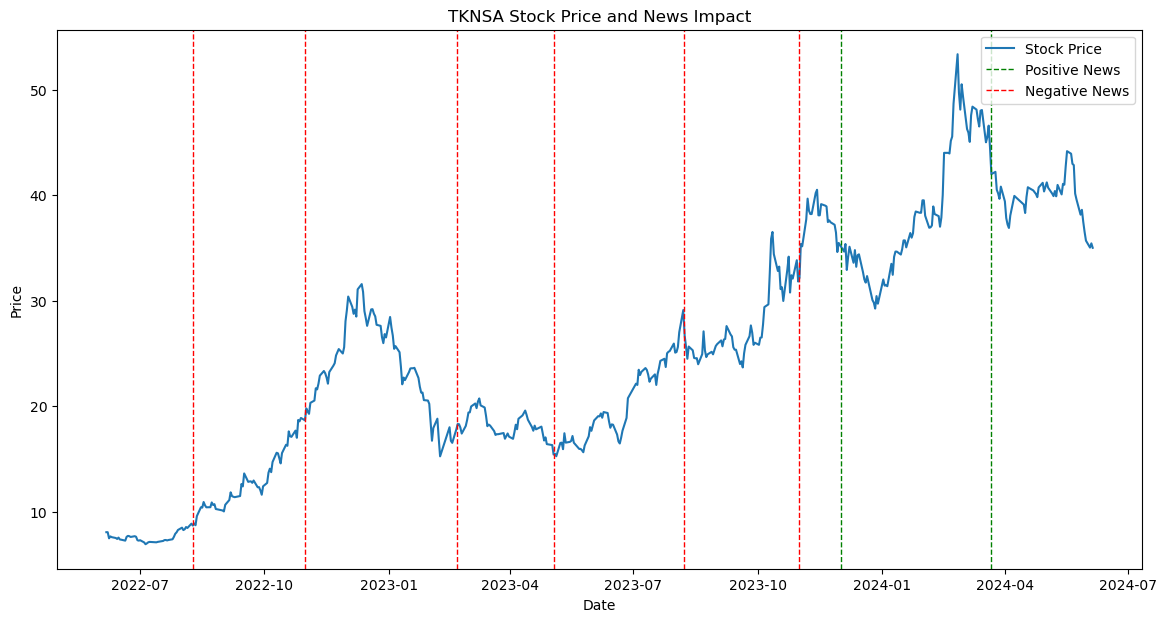

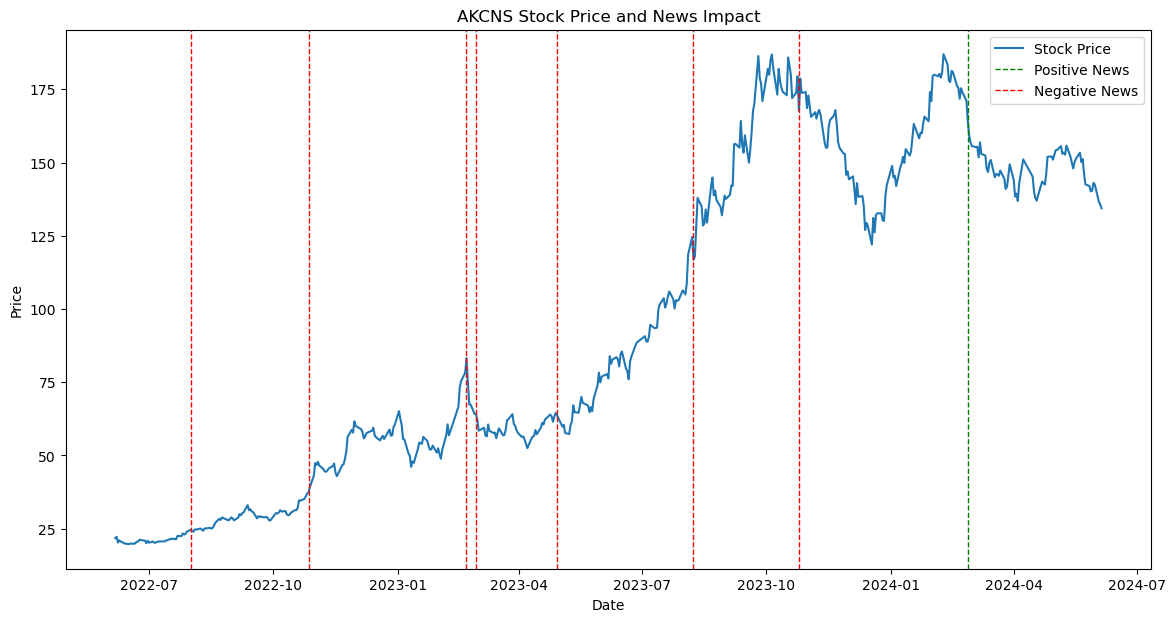

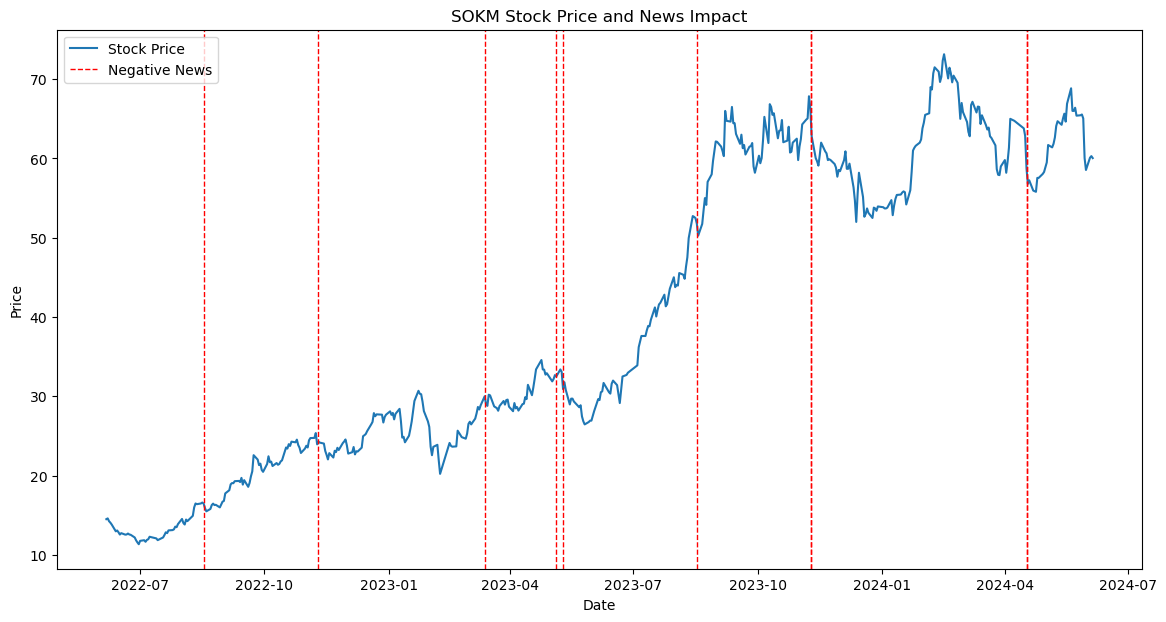

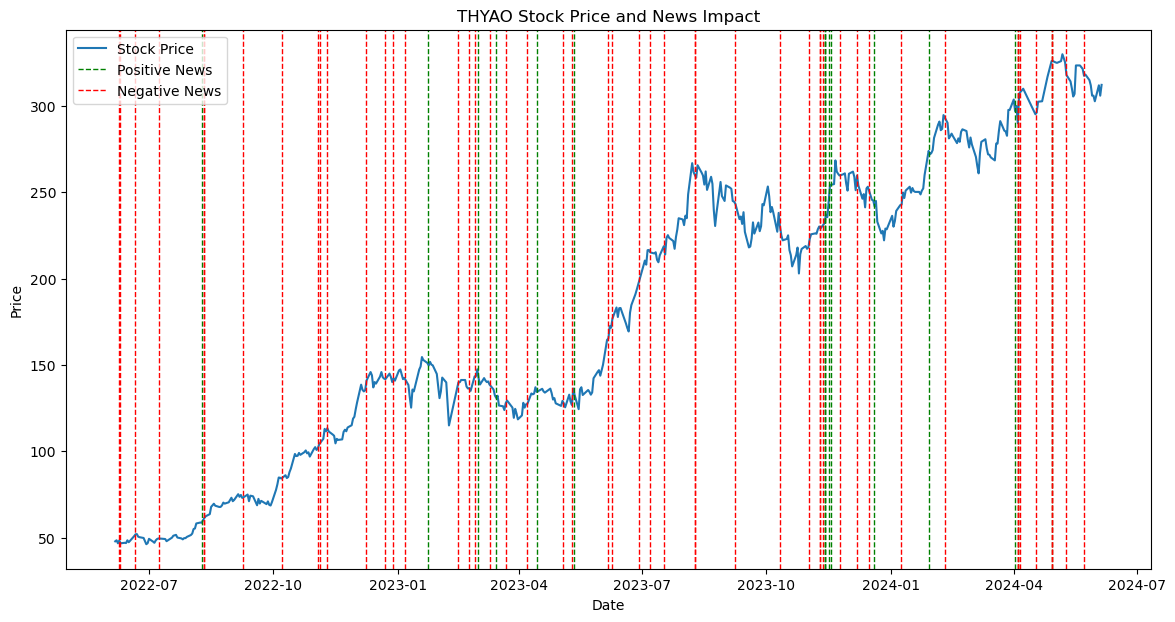

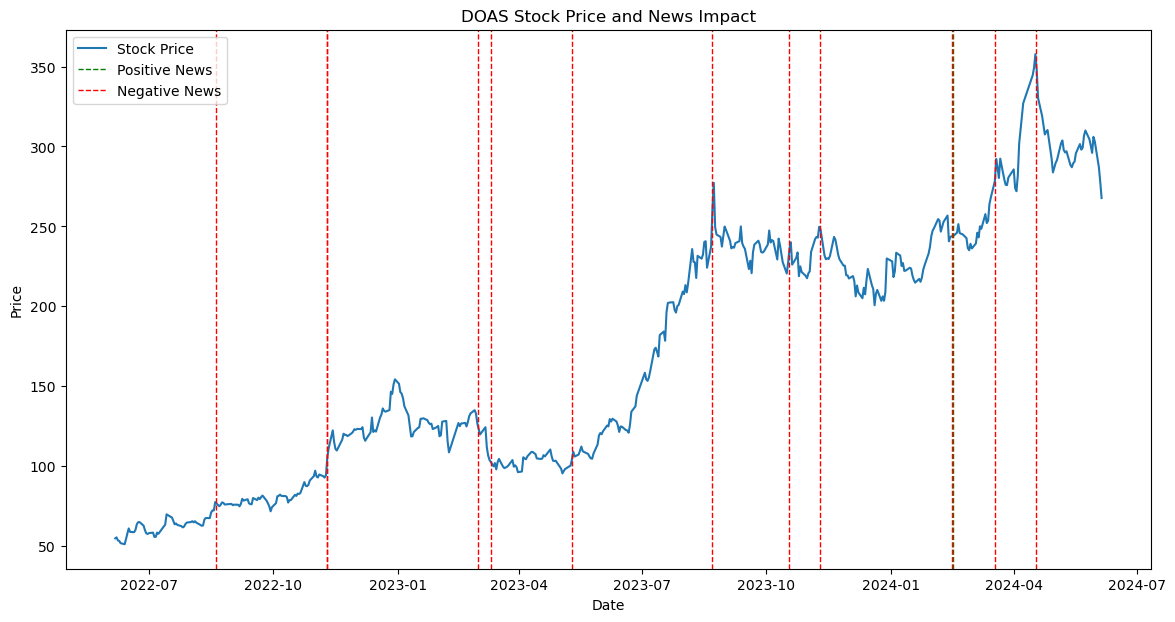

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime

# Haber başlıkları ve hisse senedi fiyat verilerini okuma
news_df = pd.read_csv("C:\\Users\\SERDAR\\Documents\\Okul\\Uskudar_Universitesi\\Dogal_dil_isleme\\final\\news_headlines_with_sentiment.csv")
price_df = pd.read_csv("C:\\Users\\SERDAR\\Documents\\Okul\\Uskudar_Universitesi\\Dogal_dil_isleme\\final\\stock_prices.csv")

# Tarihleri datetime formatına çevirme
news_df['Date'] = pd.to_datetime(news_df['Date'])
price_df['Date'] = pd.to_datetime(price_df['Date'])

# Her şirket için analiz yapma
symbols = news_df['Symbol'].unique()

for symbol in symbols:
    company_news = news_df[news_df['Symbol'] == symbol]
    company_price = price_df[price_df['Symbol'] == symbol]
    
    positive_dates = company_news[company_news['Sentiment'] == 'Positive']['Date']
    negative_dates = company_news[company_news['Sentiment'] == 'Negative']['Date']
    
    plt.figure(figsize=(14, 7))
    plt.plot(company_price['Date'], company_price['Close'], label='Stock Price')
    
    for date in positive_dates:
        plt.axvline(pd.to_datetime(date), color='g', linestyle='--', linewidth=1, label='Positive News' if date == positive_dates.iloc[0] else "")
    
    for date in negative_dates:
        plt.axvline(pd.to_datetime(date), color='r', linestyle='--', linewidth=1, label='Negative News' if date == negative_dates.iloc[0] else "")
    
    plt.title(f'{symbol} Stock Price and News Impact')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

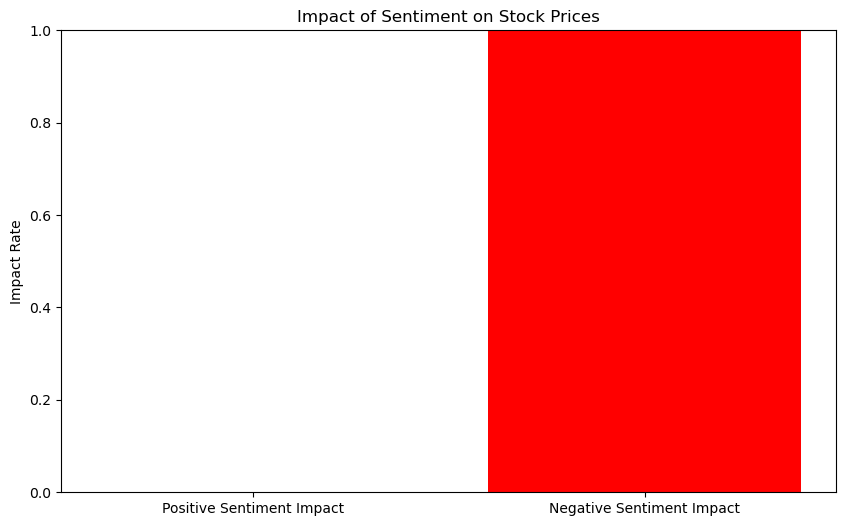

(                 Date Sentiment  Price Change    Impact
 0 2024-03-21 06:23:56  Positive   -238.305950  Negative
 1 2023-12-01 06:19:12  Positive   -182.788544  Negative
 2 2023-10-31 05:37:03  Negative   -185.431370  Negative
 3 2023-08-07 15:34:34  Negative   -209.153999  Negative
 4 2023-05-03 05:24:10  Negative    -80.036999  Negative,
 0.0,
 1.0)

In [30]:
import matplotlib.pyplot as plt
import pandas as pd

# Verileri yükleme
news_df = pd.read_csv("C:\\Users\\SERDAR\\Documents\\Okul\\Uskudar_Universitesi\\Dogal_dil_isleme\\final\\news_headlines_with_sentiment.csv")
price_df = pd.read_csv("C:\\Users\\SERDAR\\Documents\\Okul\\Uskudar_Universitesi\\Dogal_dil_isleme\\final\\stock_prices.csv")

# Tarihleri datetime formatına çevirme ve zaman dilimi farkını giderme
news_df['Date'] = pd.to_datetime(news_df['Date']).dt.tz_localize(None)
price_df['Date'] = pd.to_datetime(price_df['Date']).dt.tz_localize(None)

# Pozitif ve negatif haberlerin fiyat değişikliklerini analiz etme
def analyze_impact(news_df, price_df):
    results = []

    for index, row in news_df.iterrows():
        date = row['Date']
        sentiment = row['Sentiment']

        # İlgili tarih aralığını bulma (bir gün öncesi ve sonrası)
        price_before = price_df[price_df['Date'] < date].iloc[-1]['Close'] if not price_df[price_df['Date'] < date].empty else None
        price_after = price_df[price_df['Date'] > date].iloc[0]['Close'] if not price_df[price_df['Date'] > date].empty else None

        if price_before is not None and price_after is not None:
            price_change = price_after - price_before
            results.append({
                'Date': date,
                'Sentiment': sentiment,
                'Price Change': price_change,
                'Impact': 'Positive' if price_change > 0 else 'Negative'
            })

    return pd.DataFrame(results)

# Analizi gerçekleştirme
impact_df = analyze_impact(news_df, price_df)

# Pozitif ve negatif sentiment sonuçlarının etkilerini hesaplama
positive_sentiment = impact_df[impact_df['Sentiment'] == 'Positive']
negative_sentiment = impact_df[impact_df['Sentiment'] == 'Negative']

positive_impact = positive_sentiment[positive_sentiment['Impact'] == 'Positive']
negative_impact = negative_sentiment[negative_sentiment['Impact'] == 'Negative']

positive_rate = len(positive_impact) / len(positive_sentiment) if len(positive_sentiment) > 0 else 0
negative_rate = len(negative_impact) / len(negative_sentiment) if len(negative_sentiment) > 0 else 0

# Sonuçları görselleştirme
labels = ['Positive Sentiment Impact', 'Negative Sentiment Impact']
rates = [positive_rate, negative_rate]

plt.figure(figsize=(10, 6))
plt.bar(labels, rates, color=['green', 'red'])
plt.ylabel('Impact Rate')
plt.title('Impact of Sentiment on Stock Prices')
plt.ylim(0, 1)
plt.show()

# Sonuçların detaylarını gösterme
impact_df.head(), positive_rate, negative_rate


## Sonuç ve Öneriler

Bu proje, sınırlı veri seti ve az sayıda şirket için yapılmış bir analizdir. Daha geniş bir veri seti ve daha fazla şirket için benzer analizler yapılması gerekmektedir. Haber başlıkları, hisse senedi fiyatlarını tahmin etme kapsamında tek başına belirleyici olmayabilir; ancak diğer parametrelerle beraber kullanıldığında değerli bir parametre olabilir.

### Negatif Haberlerin Etkisi
- Negatif haber başlıklarının hisse senedi fiyatları üzerinde negatif bir etkiye sahip olduğu gözlemlendi.
- Negatif sentiment'in negatif etki oranı %100 olarak hesaplandı.

### Pozitif Haberlerin Etkisi
- Pozitif haber başlıklarının hisse senedi fiyatları üzerinde beklenen pozitif etkiye sahip olmadığı gözlemlendi.
- Pozitif sentiment'in pozitif etki oranı %0 olarak hesaplandı.

### Yorumlar ve Değerlendirme
- Negatif haberlerin hisse senedi fiyatlarını beklenildiği gibi negatif etkilediği gözlemlendi.
- Pozitif haberlerin ise hisse senedi fiyatları üzerinde beklenen pozitif etkiyi yaratmadığı, diğer faktörlerin bu etkiyi gölgelediği veya piyasanın pozitif haberlere tepki vermemiş olabileceği düşünüldü.
- İlgili zaman diliminde, üzerinde çalışılan şirketlerin negatif haberlerinin, özellikle şirket fiyatlarının düşüş trendinde olduğu dönemlerde etkili sonuç verdiği gözlemlenmiştir.

### Gelecekteki Çalışmalar için Öneriler

- **Daha Fazla Veri ve Şirket**: Daha geniş bir veri seti ve daha fazla şirket için analizler yapılabilir.
- **Detaylı Sentiment Analizi**: Haberlerin tonunu ve içeriğini daha detaylı analiz ederek sentiment analizini geliştirebiliriz.
- **Ekonomik ve Pazar Verileri**: Diğer makroekonomik faktörleri ve pazar verilerini de dahil ederek daha kapsamlı bir analiz yapılabilir.
- **Zaman Serisi Modelleri**: Zaman serisi analizleri (ARIMA, LSTM) kullanılarak daha derinlemesine tahminler yapılabilir.
- **Makine Öğrenmesi Modelleri**: Farklı makine öğrenmesi modelleri (Random Forest, Gradient Boosting) kullanılarak analiz yapılabilir.

Bu proje, hisse senedi fiyatları üzerindeki haber etkisini incelemek için önemli bir adım olup, daha kapsamlı analizler için temel oluşturabilir.
